In [1]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import pickle
from InterfaceDeclaration import LPBFData
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torchvision
import torchvision.transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder  
sys.path.append("./utils")
sys.path.append("./models")
import os
from MLUtls import LPBFDataset, get_max_length, transform_pad, fade_in_out

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

with open(os.path.join(os.path.dirname(daq_dir),'intermediate',f"lpbf_line_wise_data.pkl"), 'rb') as handle:
    lpbf_data = pickle.load(handle)

In [2]:
le_speed = LabelEncoder().fit(np.asarray(lpbf_data.scanning_speed,dtype=str))
le_region = LabelEncoder().fit(np.asarray(lpbf_data.regime_info,dtype=str))

In [3]:
sc_power = StandardScaler().fit(np.unique(lpbf_data.laser_power).astype(float).reshape(-1,1))
# sc_direction = StandardScaler().fit(np.unique(lpbf_data.print_vector[1]).astype(float).reshape(-1,1))
le_speed = LabelEncoder().fit(np.asarray(lpbf_data.scanning_speed,dtype=str))
le_region = LabelEncoder().fit(np.asarray(lpbf_data.regime_info,dtype=str))
le_direction = LabelEncoder().fit(np.unique(np.asarray(np.round(lpbf_data.print_vector[1]),dtype=str)))

laser_power = sc_power.transform(np.asarray(lpbf_data.laser_power).astype(float).reshape(-1,1)).reshape(-1)
# print_direction = sc_direction.transform(np.asarray(np.round(lpbf_data.print_vector[1])).astype(int).reshape(-1,1)).reshape(-1)
print_direction = le_direction.transform(np.asarray(np.round(lpbf_data.print_vector[1]),dtype=str)).astype(int)
scanning_speed = le_speed.transform(np.asarray(lpbf_data.scanning_speed, dtype=str).astype(int))
regime_info = le_region.transform(np.asarray(lpbf_data.regime_info,dtype=str))

In [7]:
with open(os.path.join('outputs',"intermediate",f"sc_power.pkl"), 'wb') as handle:
    pickle.dump(sc_power,handle)

with open(os.path.join('outputs',"intermediate",f"le_speed.pkl"), 'wb') as handle:
    pickle.dump(le_speed,handle)

with open(os.path.join('outputs',"intermediate",f"le_region.pkl"), 'wb') as handle:
    pickle.dump(le_region,handle)

with open(os.path.join('outputs',"intermediate",f"le_direction.pkl"), 'wb') as handle:
    pickle.dump(le_direction,handle)

In [4]:
input_list = "mic+direction".split("+")

In [5]:
np.unique(lpbf_data.cube_position)

array([0, 1, 2, 3, 4])

In [6]:
from models.MLUtls import LPBFDataset,  transform_pad, fade_in_out,transform_ft, standardize_tensor
from models.MLModels import CNN_Base_1D_Model

In [7]:
dataset = LPBFDataset(lpbf_data.cube_position,laser_power,lpbf_data.scanning_speed,regime_info,print_direction,lpbf_data.microphone, lpbf_data.AE, lpbf_data.defect_labels)
dataloader = DataLoader(dataset,batch_size=8)

In [8]:
meta_list = []
_cube_position, _laser_power, _scanning_speed, _regime_info, _print_direction, _microphone, _ae, _defect_labels = next(iter(dataloader))

In [9]:
time_series = (transform_ft()(standardize_tensor(_ae))).double()
meta_list.append(_laser_power.double())
_ae.shape, time_series.shape

(torch.Size([8, 11777]), torch.Size([8, 5888]))

In [99]:
class CNN_Base_1D_Model(nn.Module):
    def __init__(self,time_series_length=1920, meta_data_size=4, meta_network_out_ratio = 4, num_classes=3,dropout=0.2):
        super().__init__()
        self.time_series_length = time_series_length
        self.meta_data_size = meta_data_size
        meta_network_out = meta_data_size*meta_network_out_ratio
        # self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5)
        # self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.drop = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(self._get_conv_output_size()+meta_network_out, 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, num_classes)  
        if self.meta_data_size > 0:
            self.meta_fc1 = nn.Linear(meta_data_size, 32)  
            self.meta_fc2 = nn.Linear(32, 64)  
            self.meta_fc3 = nn.Linear(64, meta_network_out) 

    def _get_conv_output_size(self):
        # Create a dummy input with the same dimensions as the actual input
        dummy_input = torch.zeros(1, 1, self.time_series_length)  # Batch size, channels, input length
        output = self._forward_conv(dummy_input)
        return int(torch.prod(torch.tensor(output.size()[1:])))  # Flattened size

    def _forward_conv(self, x):
        # x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        # x = self.pool2(nn.functional.relu(self.bn2(self.conv2(x))))

        x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(nn.functional.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, time_series_data, metadata:list = None):
        x = time_series_data.unsqueeze(1)  # Add a channel dimension
        x = self._forward_conv(x)
        x = self.drop(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        print(x.shape)

        if self.meta_data_size>0:
            # Meta network
            metadata = torch.stack(metadata, dim=1)
            metadata = self.meta_fc1(metadata)
            metadata = self.meta_fc2(metadata)
            metadata = self.meta_fc3(metadata)
            
            # Concatenate metadata with the CNN output
            x = torch.cat([x, metadata], dim=1)
            print(x.shape)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = torch.sigmoid(self.fc3(x))  # Binary outputs
        return output


time_series_length = 5888
meta_data_size = len(meta_list)
time_series_length+meta_data_size
model = CNN_Base_1D_Model(time_series_length=time_series_length,meta_data_size=meta_data_size,num_classes=4).double()

In [100]:
dummy_input = torch.zeros(1, 1, time_series_length)
output = model._forward_conv(dummy_input.double())
int(torch.prod(torch.tensor(output.size()[1:]))), model.fc1

(47104, Linear(in_features=47108, out_features=64, bias=True))

In [101]:
logits = model(time_series,meta_list)
probs = torch.sigmoid(logits)
predictions = torch.argmax(probs,axis=1).clone().int().detach().cpu()
# predictions == _regime_info
logits

torch.Size([8, 47104])
torch.Size([8, 47108])


tensor([[0.4735, 0.4841, 0.5010, 0.4755],
        [0.4736, 0.4712, 0.4881, 0.4800],
        [0.4700, 0.5028, 0.5154, 0.4866],
        [0.4791, 0.4778, 0.4914, 0.4851],
        [0.5025, 0.4967, 0.4998, 0.4837],
        [0.4362, 0.4758, 0.4848, 0.4848],
        [0.4690, 0.4810, 0.5190, 0.4920],
        [0.4709, 0.4999, 0.5090, 0.4762]], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)

In [81]:
model.meta_data_size

1

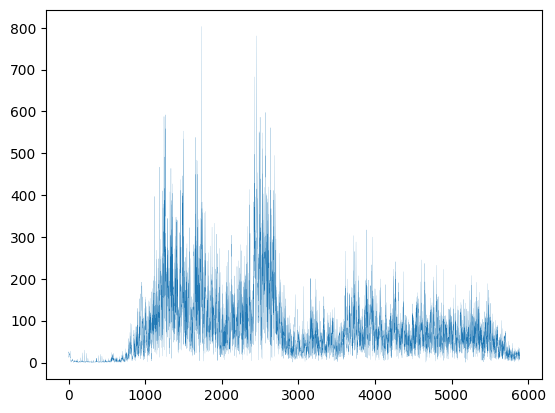

In [21]:
import matplotlib.pyplot as plt
plt.plot(time_series[4],lw=0.1)

In [19]:
torch.argmax(probs,axis=1)

tensor([1, 1, 2, 1, 1, 1, 1, 1])

In [ ]:
from models.MLUtls import fade_in_out, standardize_tensor, CylinderDataset,LCVDataset, getKFoldCrossValidationIndexes, train_log, transform_ft, dataset_by_cross_validation, labels_by_classes, get_current_fold_and_hist, LPBFDataset
folds = getKFoldCrossValidationIndexes(10000, 10, seed=10086)

In [27]:
train_idx, test_idx = folds[0]